# MCMC

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# # If we're running on Colab, install libraries

# import sys
# IN_COLAB = 'google.colab' in sys.modules

# if IN_COLAB:
#     !pip install empiricaldist

In [ ]:
# pip install empiricaldist

In [73]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [ ]:
from utils import set_pyplot_params
set_pyplot_params()

For most of this book we've been using grid methods to approximate posterior distributions.
For models with one or two parameters, grid algorithms are fast and the results are precise enough for most practical purposes.
With three parameters, they start to be slow, and with more than three they are usually not practical.

In the previous chapter we saw that we can solve some problems using conjugate priors.
But the problems we can solve this way tend to be the same ones we can solve with grid algorithms.

For problems with more than a few parameters, the most powerful tool we have is MCMC, which stands for "Markov chain Monte Carlo".
In this context, "Monte Carlo" refers to to methods that generate random samples from a distribution.
Unlike grid methods, MCMC methods don't try to compute the posterior distribution; they sample from it instead.

It might seem strange that you can generate a sample without ever computing the distribution, but that's the magic of MCMC.

To demonstrate, we'll start by solving the World Cup problem.
Yes, again.


在本书的大部分内容中，我们一直在使用网格方法来近似后验分布。
对于具有一个或两个参数的模型，网格算法速度很快，并且结果对于大多数实际目的来说足够精确。
使用三个参数，它们开始变慢，超过三个它们通常不实用。

在上一章中，我们看到我们可以使用共轭先验来解决一些问题。
但是我们可以通过这种方式解决的问题往往与我们可以使用网格算法解决的问题相同。

对于多个参数的问题，我们拥有的最强大的工具是 MCMC，它代表“马尔可夫链蒙特卡洛”。
在这种情况下，“蒙特卡洛”指的是从分布中生成随机样本的方法。
与网格方法不同，MCMC 方法不尝试计算后验分布。他们改为从中取样。

无需计算分布就可以生成样本可能看起来很奇怪，但这就是 MCMC 的魔力。

为了演示，我们将从解决世界杯问题开始。
是的，再次。

## The World Cup Problem

In <<_PoissonProcesses>> we modeled goal scoring in football (soccer) as a Poisson process characterized by a goal-scoring rate, denoted $\lambda$.

We used a gamma distribution to represent the prior distribution of $\lambda$, then we used the outcome of the game to compute the posterior distribution for both teams.

To answer the first question, we used the posterior distributions to compute the "probability of superiority" for France.

To answer the second question, we computed the posterior predictive distributions for each team, that is, the distribution of goals we expect in a rematch.

In this chapter we'll solve this problem again using PyMC3, which is a library that provide implementations of several MCMC methods.
But we'll start by reviewing the grid approximation of the prior and the prior predictive distribution.

## 世界杯问题

在<<_PoissonProcesses>>中，我们将足球（足球）中的进球得分建模为以进球得分率为特征的泊松过程，记为$\lambda$。

我们使用 gamma 分布来表示 $\lambda$ 的先验分布，然后我们使用游戏的结果来计算两支球队的后验分布。

为了回答第一个问题，我们使用后验分布来计算法国的“优势概率”。

为了回答第二个问题，我们计算了每支球队的后验预测分布，即我们期望在复赛中的进球分布。

在本章中，我们将使用 PyMC3 再次解决这个问题，PyMC3 是一个提供多种 MCMC 方法实现的库。
但我们将从回顾先验和先验预测分布的网格近似开始。

## Grid Approximation

As we did in <<_TheGammaDistribution>> we'll use a gamma distribution with parameter $\alpha=1.4$ to represent the prior.

## 网格近似

正如我们在 <<_TheGammaDistribution>> 中所做的那样，我们将使用带有参数 $\alpha=1.4$ 的伽马分布来表示先验。

In [9]:
from scipy.stats import gamma

alpha = 1.4
prior_dist = gamma(alpha)

I'll use `linspace` to generate possible values for $\lambda$, and `pmf_from_dist` to compute a discrete approximation of the prior.

我将使用 `linspace` 为 $\lambda$ 生成可能的值，并使用 `pmf_from_dist` 来计算先验的离散近似值。

In [10]:
import numpy as np
from utils import pmf_from_dist

lams = np.linspace(0, 10, 101)
prior_pmf = pmf_from_dist(prior_dist, lams)

We can use the Poisson distribution to compute the likelihood of the data; as an example, we'll use 4 goals.

我们可以使用泊松分布来计算数据的似然性； 例如，我们将使用 4 个目标。

In [11]:
from scipy.stats import poisson

data = 4
likelihood = poisson.pmf(data, lams)

Now we can do the update in the usual way.
现在我们可以按照通常的方式进行更新了。

In [12]:
posterior = prior_pmf * likelihood
posterior.normalize()

0.05015532557804499

Soon we will solve the same problem with PyMC3, but first it will be useful to introduce something new: the prior predictive distribution.

很快我们将用 PyMC3 解决同样的问题，但首先引入一些新的东西会很有用：先验预测分布。

## Prior Predictive Distribution

We have seen the posterior predictive distribution in previous chapters; the prior predictive distribution is similar except that (as you might have guessed) it is based on the prior.

To estimate the prior predictive distribution, we'll start by drawing a sample from the prior.

## 先验预测分布

我们在前面的章节中已经看到了后验预测分布； 先验预测分布是相似的，除了（正如您可能已经猜到的）它是基于先验的。

为了估计先验预测分布，我们将从先验样本开始。

In [13]:
sample_prior = prior_dist.rvs(1000)

The result is an array of possible values for the goal-scoring rate, $\lambda$.
For each value in `sample_prior`, I'll generate one value from a Poisson distribution.

结果是目标得分率 $\lambda$ 的可能值数组。
对于“sample_prior”中的每个值，我将从泊松分布中生成一个值。

In [14]:
from scipy.stats import poisson

sample_prior_pred = poisson.rvs(sample_prior)

`sample_prior_pred` is a sample from the prior predictive distribution.
To see what it looks like, we'll compute the PMF of the sample.

`sample_prior_pred` 是来自先验预测分布的样本。
要查看它的外观，我们将计算样本的 PMF。

In [15]:
from empiricaldist import Pmf

pmf_prior_pred = Pmf.from_seq(sample_prior_pred)

And here's what it looks like:

这就是它的样子：

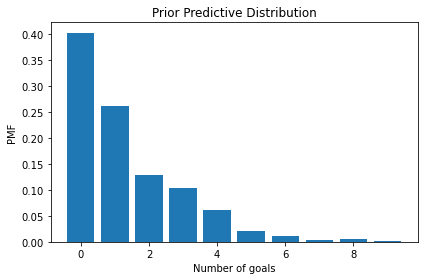

In [16]:
from utils import decorate

pmf_prior_pred.bar()
decorate(xlabel='Number of goals',
         ylabel='PMF',
         title='Prior Predictive Distribution')

One reason to compute the prior predictive distribution is to check whether our model of the system seems reasonable.
In this case, the distribution of goals seems consistent with what we know about World Cup football.

But in this chapter we have another reason: computing the prior predictive distribution is a first step toward using MCMC.

计算先验预测分布的一个原因是检查我们的系统模型是否合理。
在这种情况下，进球的分布似乎与我们对世界杯足球的了解一致。

但在本章中，我们还有另一个原因：计算先验预测分布是使用 MCMC 的第一步。

## Introducing PyMC3

PyMC3 is a Python library that provides several MCMC methods.
To use PyMC3, we have to specify a model of the process that generates the data.
In this example, the model has two steps:

* First we draw a goal-scoring rate from the prior distribution,

* Then we draw a number of goals from a Poisson distribution.

Here's how we specify this model in PyMC3:

## 介绍 PyMC3

PyMC3 是一个提供多种 MCMC 方法的 Python 库。
要使用 PyMC3，我们必须指定生成数据的过程模型。
在这个例子中，模型有两个步骤：

* 首先，我们从先验分布中得出进球得分率，

* 然后我们从泊松分布中得出一些目标。

以下是我们在 PyMC3 中指定此模型的方式：

In [ ]:
import scipy
scipy.__version__

In [ ]:
# pip uninstall scipy

In [ ]:
#  !pip install pymc3  ###scipy>=1.7.3

In [1]:
import pymc3 as pm

with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

After importing `pymc3`, we create a `Model` object named `model`.

If you are not familiar with the `with` statement in Python, it is a way to associate a block of statements with an object.
In this example, the two indented statements are associated with the new `Model` object.  As a result, when we create the distribution objects, `Gamma` and `Poisson`, they are added to the `Model`.

Inside the `with` statement:

* The first line creates the prior, which is a gamma distribution with the given parameters.

* The second line creates the prior predictive, which is a Poisson distribution with the parameter `lam`.

The first parameter of `Gamma` and `Poisson` is a string variable name.

导入 `pymc3` 后，我们创建了一个名为 `model` 的 `Model` 对象。

如果您不熟悉 Python 中的 `with` 语句，它是一种将语句块与对象关联的方法。
在此示例中，两个缩进语句与新的“模型”对象相关联。 结果，当我们创建分布对象`Gamma`和`Poisson`时，它们被添加到`Model`中。

在 `with` 语句中：

* 第一行创建先验，它是具有给定参数的伽马分布。

* 第二行创建了先验预测，它是一个带有参数“lam”的泊松分布。

`Gamma` 和 `Poisson` 的第一个参数是字符串变量名。

PyMC3 provides a function that generates a visual representation of the model.

PyMC3 提供了一个生成模型可视化表示的函数。

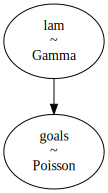

In [2]:
pm.model_to_graphviz(model)

In this visualization, the ovals show that `lam` is drawn from a gamma distribution and `goals` is drawn from a Poisson distribution.
The arrow shows that the values of `lam` are used as parameters for the distribution of `goals`.

在这个可视化中，椭圆显示“lam”是从伽马分布中绘制的，“goals”是从泊松分布中绘制的。
箭头显示“lam”的值被用作“goals”分布的参数。

## Sampling the Prior

PyMC3 provides a function that generates samples from the prior and prior predictive distributions.
We can use a `with` statement to run this function in the context of the model.

## 采样先验

PyMC3 提供了一个从先验和先验预测分布生成样本的函数。
我们可以使用 `with` 语句在模型的上下文中运行此函数。

In [3]:
with model:
    trace = pm.sample_prior_predictive(1000)

In [4]:
len(trace)


3

The result is a dictionary-like object that maps from the variables, `lam` and `goals`, to the samples.
We can extract the sample of `lam` like this:

结果是一个类似字典的对象，它从变量“lam”和“goals”映射到样本。
我们可以像这样提取“lam”的样本：

In [5]:
sample_prior_pymc = trace['lam']
sample_prior_pymc.shape

(1000,)

The following figure compares the CDF of this sample to the CDF of the sample we generated using the `gamma` object from SciPy.

下图将此样本的 CDF 与我们使用 SciPy 中的 `gamma` 对象生成的样本的 CDF 进行了比较。

In [6]:
from empiricaldist import Cdf

def plot_cdf(sample, **options):
    """Plot the CDF of a sample.
    
    sample: sequence of quantities
    """
    Cdf.from_seq(sample).plot(**options)

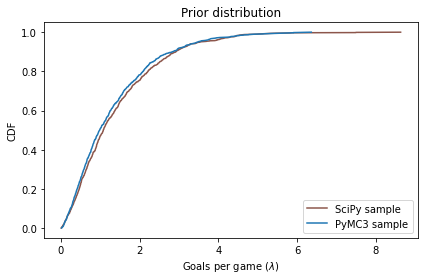

In [17]:
plot_cdf(sample_prior, 
         label='SciPy sample',
         color='C5')
plot_cdf(sample_prior_pymc, 
         label='PyMC3 sample',
         color='C0')
decorate(xlabel=r'Goals per game ($\lambda$)',
         ylabel='CDF',
         title='Prior distribution')

The results are similar, which confirms that the specification of the model is correct and the sampler works as advertised.

From the trace we can also extract `goals`, which is a sample from the prior predictive distribution.

结果相似，这证实了模型的规格是正确的，并且采样器的工作原理与宣传的一样。

从跟踪中，我们还可以提取“目标”，它是先验预测分布的样本。

In [18]:
sample_prior_pred_pymc = trace['goals']
sample_prior_pred_pymc.shape

(1000,)

In [19]:
sample_prior_pred_pymc

array([0, 0, 0, 3, 1, 1, 3, 1, 0, 2, 4, 6, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 8, 0, 1, 0, 4, 1, 3, 3, 0, 0, 1, 0, 2, 4, 1, 2, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 3, 1, 0, 2, 2, 1,
       0, 0, 2, 0, 6, 0, 1, 0, 1, 2, 1, 1, 0, 1, 6, 2, 1, 1, 1, 1, 1, 2,
       3, 1, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 1,
       5, 1, 0, 0, 0, 0, 1, 0, 3, 0, 1, 2, 1, 2, 0, 0, 2, 5, 2, 4, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 6, 0, 0, 3, 0, 1, 2, 5, 0, 2, 6,
       3, 3, 1, 0, 0, 1, 6, 0, 2, 1, 1, 4, 0, 1, 2, 0, 1, 3, 1, 3, 0, 1,
       2, 0, 3, 0, 1, 1, 0, 2, 7, 3, 1, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2,
       0, 2, 0, 0, 1, 6, 0, 0, 0, 0, 0, 1, 0, 0, 2, 3, 0, 0, 2, 6, 0, 1,
       0, 0, 0, 3, 4, 2, 1, 1, 0, 4, 0, 3, 4, 1, 1, 3, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 4, 2, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 2, 2, 2, 1, 3,
       2, 0, 5, 1, 4, 0, 0, 1, 1, 1, 1, 2, 3, 2, 2, 2, 0, 0, 2, 1, 1, 0,
       1, 3, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 1, 1, 2,

And we can compare it to the sample we generated using the `poisson` object from SciPy.

Because the quantities in the posterior predictive distribution are discrete (number of goals) I'll plot the CDFs as step functions.

我们可以将它与我们使用 SciPy 中的“泊松”对象生成的样本进行比较。

因为后验预测分布中的数量是离散的（目标数量），所以我将 CDF 绘制为阶跃函数。

In [20]:
def plot_pred(sample, **options):
    Cdf.from_seq(sample).step(**options)

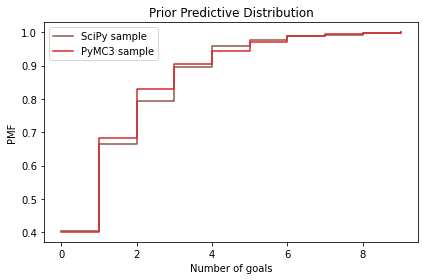

In [21]:
plot_pred(sample_prior_pred, 
          label='SciPy sample', 
          color='C5')
plot_pred(sample_prior_pred_pymc, 
          label='PyMC3 sample', 
          color='C13')
decorate(xlabel='Number of goals',
         ylabel='PMF',
         title='Prior Predictive Distribution')

Again, the results are similar, so we have some confidence we are using PyMC3 right.
同样，结果相似，所以我们有信心使用 PyMC3 是正确的。

## When Do We Get to Inference?

Finally, we are ready for actual inference.  We just have to make one small change.
Here is the model we used to generate the prior predictive distribution:
## 我们什么时候开始推理？

最后，我们准备好进行实际推理了。 我们只需要做一个小小的改变。
这是我们用来生成先验预测分布的模型：

In [22]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

And here is the model we'll use to compute the posterior distribution.

这是我们将用来计算后验分布的模型。

In [23]:
with pm.Model() as model2:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam, observed=4)

The difference is that we mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `lam`.

不同之处在于我们将目标标记为“观察到”并提供观察到的数据“4”。

而不是调用 `sample_prior_predictive`，我们将调用 `sample`，这被理解为从 `lam` 的后验分布中采样。

In [24]:
options = dict(return_inferencedata=False)

with model2:
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8917533684584796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800444662355612, but should be close to 0.8. Try to increase the number of tuning steps.


Although the specification of these models is similar, the sampling process is very different.
I won't go into the details of how PyMC3 works, but here are a few things you should be aware of:

* Depending on the model, PyMC3 uses one of several MCMC methods; in this example, it uses the [No U-Turn Sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler) (NUTS), which is one of the most efficient and reliable methods we have.

* When the sampler starts, the first values it generates are usually not a representative sample from the posterior distribution, so these values are discarded.  This process is called "tuning".

* Instead of using a single Markov chain, PyMC3 uses multiple chains.  Then we can compare results from multiple chains to make sure they are consistent.

Although we asked for a sample of 500, PyMC3 generated two samples of 1000, discarded half of each, and returned the remaining 1000.
From `trace2` we can extract a sample from the posterior distribution, like this:

尽管这些模型的规格相似，但采样过程却大不相同。
我不会详细介绍 PyMC3 的工作原理，但您应该注意以下几点：

* 根据模型，PyMC3 使用几种 MCMC 方法之一；在此示例中，它使用 [No U-Turn Sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler) (NUTS)，这是我们拥有的最有效和最可靠的方法之一。

* 当采样器启动时，它生成的第一个值通常不是后验分布的代表性样本，因此这些值被丢弃。这个过程称为“调整”。

* PyMC3 不使用单个马尔可夫链，而是使用多个链。然后我们可以比较多个链的结果，以确保它们是一致的。

虽然我们要求一个 500 个样本，但 PyMC3 生成了两个 1000 个样本，丢弃了每个样本的一半，并返回了剩余的 1000 个。
从 `trace2` 我们可以从后验分布中提取样本，如下所示：

In [25]:
sample_post_pymc = trace2['lam']

In [26]:
sample_post_pymc.shape

(2000,)

And we can compare the CDF of this sample to the posterior we computed by grid approximation:

我们可以将该样本的 CDF 与我们通过网格近似计算的后验进行比较：

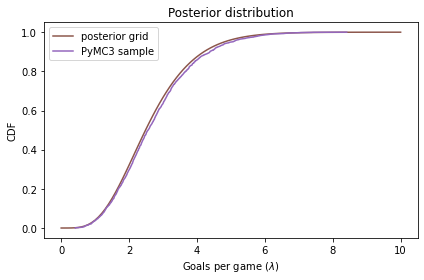

In [27]:
posterior.make_cdf().plot(label='posterior grid', 
                          color='C5')
plot_cdf(sample_post_pymc, 
         label='PyMC3 sample',
         color='C4')

decorate(xlabel=r'Goals per game ($\lambda$)',
         ylabel='CDF',
         title='Posterior distribution')

The results from PyMC3 are consistent with the results from the grid approximation.

PyMC3 的结果与网格近似的结果一致。

## Posterior Predictive Distribution

Finally, to sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

## 后验预测分布

最后，为了从后验预测分布中采样，我们可以使用“sample_posterior_predictive”：

In [28]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

The result is a dictionary that contains a sample of `goals`.

结果是一个包含“目标”样本的字典。

In [29]:
sample_post_pred_pymc = post_pred['goals']

In [30]:
sample_post_pred_pymc.shape

(2000,)

I'll also generate a sample from the posterior distribution we computed by grid approximation.
我还将根据我们通过网格近似计算的后验分布生成一个样本。

In [31]:
sample_post = posterior.sample(1000)
sample_post_pred = poisson(sample_post).rvs()

And we can compare the two samples.
我们可以比较两个样本。

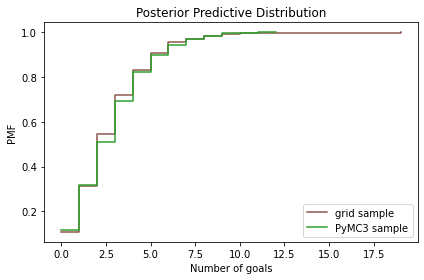

In [32]:
plot_pred(sample_post_pred, 
          label='grid sample',
          color='C5')
plot_pred(sample_post_pred_pymc, 
          label='PyMC3 sample',
          color='C12')

decorate(xlabel='Number of goals',
         ylabel='PMF',
         title='Posterior Predictive Distribution')

Again, the results are consistent.
So we've established that we can compute the same results using a grid approximation or PyMC3.

But it might not be clear why.
In this example, the grid algorithm requires less computation than MCMC, and the result is a pretty good approximation of the posterior distribution, rather than a sample.

However, this is a simple model with just one parameter.
In fact, we could have solved it with even less computation, using a conjugate prior.
The power of PyMC3 will be clearer with a more complex model.

同样，结果是一致的。
所以我们已经确定我们可以使用网格近似或 PyMC3 计算相同的结果。

但可能不清楚为什么。
在这个例子中，网格算法比 MCMC 需要更少的计算，结果是后验分布的一个很好的近似，而不是一个样本。

然而，这是一个只有一个参数的简单模型。
事实上，我们可以用更少的计算来解决它，使用共轭先验。
PyMC3 的威力会随着更复杂的模型而更加清晰。

## Happiness

Recently I read ["Happiness and Life Satisfaction"](https://ourworldindata.org/happiness-and-life-satisfaction)
by Esteban Ortiz-Ospina and Max Roser, which discusses (among many other things) the relationship between income and happiness, both between countries, within countries, and over time.

It cites the ["World Happiness Report"](https://worldhappiness.report/), which includes [results of a multiple regression analysis](https://worldhappiness.report/ed/2020/social-environments-for-world-happiness/) that explores the relationship between happiness and six potentially predictive factors:

* Income as represented by per capita GDP

* Social support

* Healthy life expectancy at birth

* Freedom to make life choices

* Generosity

* Perceptions of corruption

## 幸福

最近看了[《幸福与生活满意度》](https://ourworldindata.org/happiness-and-life-satisfaction)
由 Esteban Ortiz-Ospina 和 Max Roser 撰写，其中讨论了（除其他外）收入与幸福之间的关系，无论是在国家之间、国家内部还是随着时间的推移。

它引用了[“世界幸福报告”](https://worldhappiness.report/)，其中包括[多元回归分析的结果](https://worldhappiness.report/ed/2020/social-environments-for-world-happiness/) 探索幸福与六个潜在预测因素之间的关系：

* 以人均 GDP 表示的收入

* 社会支持

*出生时的健康预期寿命

* 自由选择生活

* 慷慨

* 对腐败的看法


The dependent variable is the national average of responses to the "Cantril ladder question" used by the [Gallup World Poll](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx):

> Please imagine a ladder with steps numbered from zero at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?

I'll refer to the responses as "happiness", but it might be more precise to think of them as a measure of satisfaction with quality of life.

In the next few sections we'll replicate the analysis in this report using Bayesian regression.


因变量是 [盖洛普世界民意调查](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx) 使用的“Cantril 阶梯问题”的全国平均回答 ):

> 请想象一个梯子，梯子的梯级从底部的 0 到顶部的 10。 梯子的顶部代表你最好的生活，梯子的底部代表你最糟糕的生活。 你会说你个人觉得你站在梯子的哪一步？

我将这些反应称为“幸福”，但将它们视为对生活质量满意度的衡量标准可能更准确。

在接下来的几节中，我们将使用贝叶斯回归复制本报告中的分析。

The data from this report can be [downloaded from here](https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls).

In [ ]:
# Get the data file

download('https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls')

We can use Pandas to read the data into a `DataFrame`.

In [34]:
import pandas as pd

filename = 'WHR20_DataForFigure2.1.csv'
df = pd.read_csv(filename)

In [35]:
df.head(3)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267


In [36]:
df.shape

(153, 20)

The `DataFrame` has one row for each of 153 countries and one column for each of 20 variables.

The column called `'Ladder score'` contains the measurements of happiness we will try to predict.

`DataFrame` 对于 153 个国家/地区中的每一个都有一行，对于 20 个变量中的每一个都有一列。

名为“阶梯分数”的列包含我们将尝试预测的幸福度测量值。

In [37]:
score = df['Ladder score']

## Simple Regression

To get started, let's look at the relationship between happiness and income as represented by gross domestic product (GDP) per person.

The column named `'Logged GDP per capita'` represents the natural logarithm of GDP for each country, divided by population, corrected for [purchasing power parity](https://en.wikipedia.org/wiki/Purchasing_power_parity) (PPP).

## 简单回归

首先，让我们看看幸福与收入之间的关系，以人均国内生产总值 (GDP) 为代表。

名为“记录的人均 GDP”的列代表每个国家 GDP 的自然对数，除以人口，校正 [购买力平价](https://en.wikipedia.org/wiki/Purchasing_power_parity) (PPP) .

In [38]:
log_gdp = df['Logged GDP per capita']

The following figure is a scatter plot of `score` versus `log_gdp`, with one marker for each country.
下图是 `score` 与 `log_gdp` 的散点图，每个国家都有一个标记。

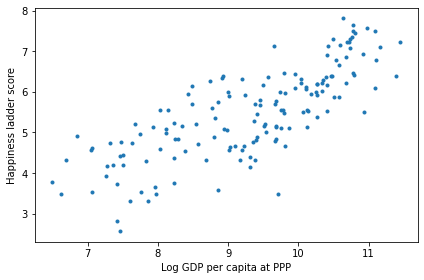

In [39]:
import matplotlib.pyplot as plt

plt.plot(log_gdp, score, '.')

decorate(xlabel='Log GDP per capita at PPP',
         ylabel='Happiness ladder score')

It's clear that there is a relationship between these variables: people in countries with higher GDP generally report higher levels of happiness.

We can use `linregress` from SciPy to compute a simple regression of these variables.

很明显，这些变量之间存在关系：GDP 较高的国家的人们通常报告的幸福水平较高。

我们可以使用 SciPy 中的“linregress”来计算这些变量的简单回归。

In [40]:
from scipy.stats import linregress

result = linregress(log_gdp, score)

And here are the results.

In [41]:
pd.DataFrame([result.slope, result.intercept],
             index=['Slope', 'Intercept'],
             columns=[''])

,
Slope,0.717738
Intercept,-1.198646


The estimated slope is about 0.72, which suggests that an increase of one unit in log-GDP, which is a factor of $e \approx 2.7$ in GDP, is associated with an increase of 0.72 units on the happiness ladder.

Now let's estimate the same parameters using PyMC3.
We'll use the same regression model as in Section <<_RegressionModel>>:

$$y = a x + b + \epsilon$$

where $y$ is the dependent variable (ladder score), $x$ is the predictive variable (log GDP) and $\epsilon$ is a series of values from a normal distribution with standard deviation $\sigma$.

$a$ and $b$ are the slope and intercept of the regression line.
They are unknown parameters, so we will use the data to estimate them.

The following is the PyMC3 specification of this model.

估计的斜率约为 0.72，这表明对数 GDP 增加一个单位，即 GDP 的 $e \approx 2.7$ 的因子，与幸福阶梯上增加 0.72 个单位相关。

现在让我们使用 PyMC3 估计相同的参数。
我们将使用与第 <<_RegressionModel>> 节中相同的回归模型：

$$y = a x + b + \epsilon$$

其中 $y$ 是因变量（阶梯分数），$x$ 是预测变量（对数 GDP），$\epsilon$ 是来自标准偏差 $\sigma$ 的正态分布的一系列值。

$a$ 和 $b$ 是回归线的斜率和截距。
它们是未知参数，因此我们将使用数据来估计它们。

以下是该模型的 PyMC3 规范。

In [42]:
x_data = log_gdp
y_data = score

with pm.Model() as model3:
    a = pm.Uniform('a', 0, 4)
    b = pm.Uniform('b', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = a * x_data + b
    y = pm.Normal('y', 
                  mu=y_est, sd=sigma, 
                  observed=y_data)

The prior distributions for the parameters `a`, `b`, and `sigma` are uniform with ranges that are wide enough to cover the posterior distributions.

`y_est` is the estimated value of the dependent variable, based on the regression equation.
And `y` is a normal distribution with mean `y_est` and standard deviation `sigma`.

参数“a”、“b”和“sigma”的先验分布是均匀的，其范围足够宽以覆盖后验分布。

`y_est` 是因变量的估计值，基于回归方程。
并且`y`是一个正态分布，平均`y_est`和标准偏差`sigma`。

Notice how the data are included in the model:

* The values of the predictive variable, `x_data`, are used to compute `y_est`.

* The values of the dependent variable, `y_data`, are provided as the observed values of `y`.

Now we can use this model to generate a sample from the posterior distribution.

注意数据是如何包含在模型中的：

* 预测变量“x_data”的值用于计算“y_est”。

* 因变量“y_data”的值作为“y”的观测值提供。

现在我们可以使用这个模型从后验分布中生成一个样本。

In [43]:
with model3:
    trace3 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8944071199276936, but should be close to 0.8. Try to increase the number of tuning steps.


When you run the sampler, you might get warning messages about "divergences" and the "acceptance probability".
You can ignore them for now.

The result is an object that contains samples from the joint posterior distribution of `a`, `b`, and `sigma`.

运行采样器时，您可能会收到有关“分歧”和“接受概率”的警告消息。
您现在可以忽略它们。

结果是一个对象，其中包含来自 `a`、`b` 和 `sigma` 的联合后验分布的样本。

In [44]:
trace3

<MultiTrace: 4 chains, 500 iterations, 6 variables>

ArviZ provides `plot_posterior`, which we can use to plot the posterior distributions of the parameters.
Here are the posterior distributions of slope, `a`, and intercept, `b`.

ArviZ 提供了 `plot_posterior`，我们可以用它来绘制参数的后验分布。
这是斜率“a”和截距“b”的后验分布。

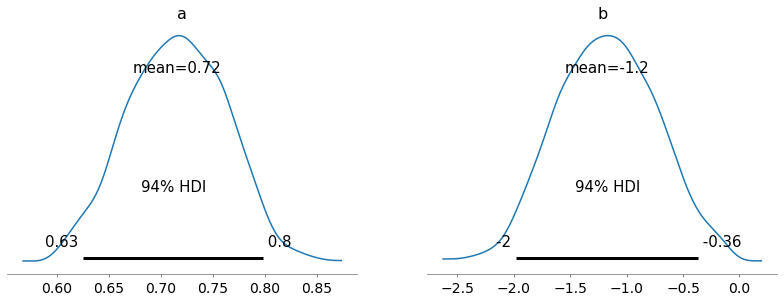

In [45]:
import arviz as az

with model3:
    az.plot_posterior(trace3, var_names=['a', 'b']);

The graphs show the distributions of the samples, estimated by KDE, and 94% credible intervals.  In the figure, "HDI" stands for ["highest-density interval"](https://www.sciencedirect.com/topics/mathematics/highest-density-interval).

The means of these samples are consistent with the parameters we estimated with `linregress`.

图表显示了由 KDE 估计的样本分布和 94% 的可信区间。 在图中，“HDI”代表[“最高密度区间”](https://www.sciencedirect.com/topics/mathematics/highest-density-interval)。

这些样本的均值与我们用“linregress”估计的参数一致。

In [46]:
print('Sample mean:', trace3['a'].mean())
print('Regression slope:', result.slope)

Sample mean: 0.7152032263700859
Regression slope: 0.7177384956354943


In [47]:
print('Sample mean:', trace3['b'].mean())
print('Regression intercept:', result.intercept)

Sample mean: -1.1740314128439562
Regression intercept: -1.1986460619042667


Finally, we can check the marginal posterior distribution of `sigma`

最后，我们可以检查 `sigma` 的边缘后验分布

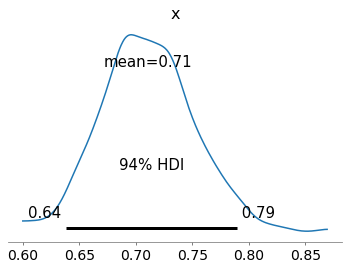

In [48]:
az.plot_posterior(trace3['sigma']);

The values in the posterior distribution of `sigma` seem plausible.

`sigma` 的后验分布中的值似乎是合理的。

The simple regression model has only three parameters, so we could have used a grid algorithm.
But the regression model in the happiness report has six predictive variables, so it has eight parameters in total, including the intercept and `sigma`.

It is not practical to compute a grid approximation for a model with eight parameters.
Even a coarse grid, with 20 points along each dimension, would have more than 25 billion points.
And with 153 countries, we would have to compute almost 4 trillion likelihoods.

But PyMC3 can handle a model with eight parameters comfortably, as we'll see in the next section.

简单回归模型只有三个参数，所以我们可以使用网格算法。
但是幸福报告中的回归模型有六个预测变量，所以它总共有八个参数，包括截距和`sigma`。

为具有八个参数的模型计算网格近似值是不切实际的。
即使是一个粗略的网格，每个维度有 20 个点，也会有超过 250 亿个点。
对于 153 个国家，我们将不得不计算近 4 万亿个可能性。

但是 PyMC3 可以轻松地处理具有八个参数的模型，我们将在下一节中看到。

In [49]:
20 ** 8 / 1e9

25.6

In [50]:
153 * 20 ** 8 / 1e12

3.9168

## Multiple Regression

Before we implement the multiple regression model, I'll select the columns we need from the `DataFrame`.

## 多重回归

在我们实现多元回归模型之前，我将从“DataFrame”中选择我们需要的列。

In [51]:
columns = ['Ladder score',
           'Logged GDP per capita',
           'Social support',
           'Healthy life expectancy',
           'Freedom to make life choices',
           'Generosity',
           'Perceptions of corruption']

subset = df[columns]

In [52]:
subset.head(3)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445
1,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489
2,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728


The predictive variables have different units: log-GDP is in log-dollars, life expectancy is in years, and the other variables are on arbitrary scales.
To make these factors comparable, I'll standardize the data so that each variable has mean 0 and standard deviation 1.

预测变量有不同的单位：log-GDP 的单位是对数美元，预期寿命的单位是年，其他变量的单位是任意的。
为了使这些因素具有可比性，我将对数据进行标准化，使每个变量的均值为 0，标准差为 1。

In [53]:
standardized = (subset - subset.mean()) / subset.std()

Now let's build the model.
I'll extract the dependent variable.

现在让我们构建模型。
我将提取因变量。

In [54]:
y_data = standardized['Ladder score']

And the dependent variables.

和因变量。

In [55]:
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

And here's the model.  `b0` is the intercept; `b1` through `b6` are the parameters associated with the predictive variables.

这是模型。 `b0` 是截距； `b1` 到 `b6` 是与预测变量相关的参数。

In [56]:
with pm.Model() as model4:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y', 
                  mu=y_est, sd=sigma, 
                  observed=y_data)

We could express this model more concisely using a vector of predictive variables and a vector of parameters, but I decided to keep it simple.

Now we can sample from the joint posterior distribution.

我们可以使用预测变量向量和参数向量更简洁地表达这个模型，但我决定保持简单。

现在我们可以从联合后验分布中采样。

In [57]:
with model4:
    trace4 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b6, b5, b4, b3, b2, b1, b0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


Because we standardized the data, we expect the intercept to be 0, and in fact the posterior mean of `b0` is close to 0.

因为我们对数据进行了标准化，所以我们期望截距为 0，实际上 `b0` 的后验均值接近 0。

In [58]:
trace4['b0'].mean()

-0.00031901211288460095

We can also check the posterior mean of `sigma`:

我们还可以检查 `sigma` 的后验均值：

In [59]:
trace4['sigma'].mean()

0.5160862452951424

From `trace4` we can extract samples from the posterior distributions of the parameters and compute their means.

从“trace4”中，我们可以从参数的后验分布中提取样本并计算它们的均值。

In [60]:
param_names = ['b1', 'b3', 'b3', 'b4', 'b5', 'b6']

means = [trace4[name].mean() 
         for name in param_names]

We can also compute 94% credible intervals (between the 3rd and 97th percentiles).

我们还可以计算 94% 的可信区间（在第 3 和第 97 个百分位数之间）。

In [61]:
def credible_interval(sample):
    """Compute 94% credible interval."""
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

cis = [credible_interval(trace4[name])
       for name in param_names]

The following table summarizes the results.
下表总结了结果。

In [62]:
index = columns[1:]
table = pd.DataFrame(index=index)
table['Posterior mean'] = np.round(means, 3)
table['94% CI'] = cis
table

,Posterior mean,94% CI
Logged GDP per capita,0.246,"[0.075, 0.414]"
Social support,0.226,"[0.062, 0.378]"
Healthy life expectancy,0.226,"[0.062, 0.378]"
Freedom to make life choices,0.189,"[0.091, 0.289]"
Generosity,0.057,"[-0.03, 0.141]"
Perceptions of corruption,-0.097,"[-0.194, -0.001]"


It looks like GDP has the strongest association with happiness (or satisfaction), followed by social support, life expectancy, and freedom.

After controlling for those other factors, the parameters of the other factors are substantially smaller, and since the CI for generosity includes 0, it is plausible that generosity is not substantially related to happiness, at least as they were measured in this study.

This example demonstrates the power of MCMC to handle models with more than a few parameters.
But it does not really demonstrate the power of Bayesian regression.

If the goal of a regression model is to estimate parameters, there is no great advantage to Bayesian regression compared to conventional least squares regression.

Bayesian methods are more useful if we plan to use the posterior distribution of the parameters as part of a decision analysis process.

看起来 GDP 与幸福（或满意度）的相关性最强，其次是社会支持、预期寿命和自由。

在控制了这些其他因素之后，其他因素的参数要小得多，并且由于慷慨的 CI 包括 0，因此慷慨与幸福没有实质关系是合理的，至少在本研究中测量它们是合理的。

这个例子展示了 MCMC 处理具有多个参数的模型的能力。
但这并没有真正展示贝叶斯回归的威力。

如果回归模型的目标是估计参数，那么与传统的最小二乘回归相比，贝叶斯回归并没有太大的优势。

如果我们计划使用参数的后验分布作为决策分析过程的一部分，贝叶斯方法会更有用。

## Summary

In this chapter we used PyMC3 to implement two models we've seen before: a Poisson model of goal-scoring in soccer and a simple regression model.
Then we implemented a multiple regression model that would not have been possible to compute with a grid approximation.

MCMC is more powerful than grid methods, but that power comes with some disadvantages:

* MCMC algorithms are fiddly.  The same model might behave well with some priors and less well with others.  And the sampling process often produces warnings about tuning steps, divergences, "r-hat statistics", acceptance rates, and effective samples.  It takes some expertise to diagnose and correct these issues.

* I find it easier to develop models incrementally using grid algorithms, checking intermediate results along the way.  With PyMC3, it is not as easy to be confident that you have specified a model correctly.

For these reasons, I recommend a model development process that starts with grid algorithms and resorts to MCMC if necessary.
As we saw in the previous chapters, you can solve a lot of real-world problems with grid methods.
But when you need MCMC, it is useful to have a grid algorithm to compare to (even if it is based on a simpler model).

All of the models in this book can be implemented in PyMC3, but some of them are easier to translate than others.
In the exercises, you will have a chance to practice.

## 概括

在本章中，我们使用 PyMC3 实现了我们之前见过的两个模型：足球进球得分的泊松模型和简单的回归模型。
然后我们实现了一个多元回归模型，该模型不可能用网格近似计算。

MCMC 比网格方法更强大，但这种能力也有一些缺点：

* MCMC 算法很繁琐。相同的模型可能在某些先验上表现良好，而在其他先验上表现不佳。并且抽样过程经常会产生关于调整步骤、分歧、“r-hat 统计”、接受率和有效样本的警告。诊断和纠正这些问题需要一些专业知识。

* 我发现使用网格算法增量开发模型更容易，同时检查中间结果。使用 PyMC3，确定您已正确指定模型并不容易。

出于这些原因，我建议从网格算法开始的模型开发过程，并在必要时求助于 MCMC。
正如我们在前几章中看到的，您可以使用网格方法解决许多实际问题。
但是当你需要 MCMC 时，有一个网格算法来比较是很有用的（即使它基于更简单的模型）。

本书中的所有模型都可以在 PyMC3 中实现，但其中一些模型比其他模型更容易翻译。
在练习中，您将有机会练习。

## Exercises

**Exercise:** As a warmup, let's use PyMC3 to solve the Euro problem.
Suppose we spin a coin 250 times and it comes up heads 140 times.
What is the posterior distribution of $x$, the probability of heads?

For the prior, use a beta distribution with parameters $\alpha=1$ and $\beta=1$.

See [the PyMC3 documentation](https://docs.pymc.io/api/distributions/continuous.html) for the list of continuous distributions.

**练习：** 作为热身，让我们使用 PyMC3 来解决欧元问题。
假设我们将一枚硬币旋转 250 次，它出现了 140 次正面。
$x$ 的后验分布是什么，正面的概率是多少？

对于先验，使用参数 $\alpha=1$ 和 $\beta=1$ 的 beta 分布。

有关连续分布的列表，请参阅 [PyMC3 文档](https://docs.pymc.io/api/distributions/continuous.html)。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


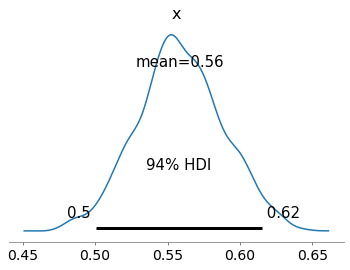

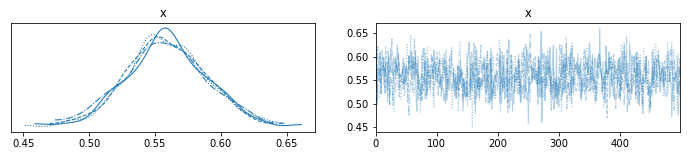

In [65]:
# Solution goes here
n=250
k_obs=140
with pm.Model() as model5:
    x = pm.Beta('x', alpha=1, beta=1.0)
    k = pm.Binomial('k',n=n,p=x,observed=k_obs)
    trace5 = pm.sample(500, **options)
    az.plot_posterior(trace5)
    az.plot_trace(trace5, var_names=['x'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


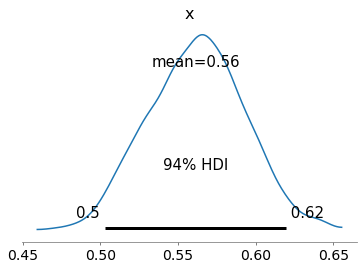

In [64]:
# Click to hide# Solution

n = 250
k_obs = 140

with pm.Model() as model5:
    x = pm.Beta('x', alpha=1, beta=1)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    trace5 = pm.sample(500, **options)
    az.plot_posterior(trace5)

**Exercise:** Now let's use PyMC3 to replicate the solution to the Grizzly Bear problem in <<_TheGrizzlyBearProblem>>, which is based on the hypergeometric distribution.

I'll present the problem with slightly different notation, to make it consistent with PyMC3.

Suppose that during the first session, `k=23` bears are tagged.  During the second session, `n=19` bears are identified, of which `x=4` had been tagged.

Estimate the posterior distribution of `N`, the number of bears in the environment.

For the prior, use a discrete uniform distribution from 50 to 500.

See [the PyMC3 documentation](https://docs.pymc.io/api/distributions/discrete.html) for the list of discrete distributions.

Note: `HyperGeometric` was added to PyMC3 after version 3.8, so you might need to update your installation to do this exercise.

**练习：** 现在让我们使用 PyMC3 来复制 <<_TheGrizzlyBearProblem>> 中灰熊问题的解决方案，它基于超几何分布。

我将用稍微不同的符号来呈现问题，以使其与 PyMC3 一致。

假设在第一个会话期间，“k=23”熊被标记。 在第二次会议期间，确定了“n=19”空头，其中“x=4”已被标记。

估计环境中熊的数量“N”的后验分布。

对于先验，使用从 50 到 500 的离散均匀分布。

有关离散分布的列表，请参阅 [PyMC3 文档](https://docs.pymc.io/api/distributions/discrete.html)。

注意：`HyperGeometric` 是在 3.8 版之后添加到 PyMC3 中的，所以你可能需要更新你的安装来做这个练习。

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [X]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


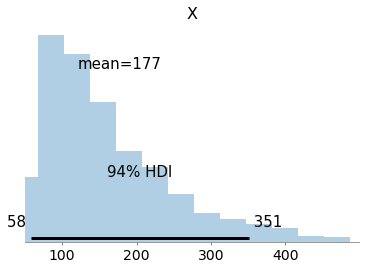

In [67]:
# Click to hide# Solution

k=23
n=19
x=4

with pm.Model() as model6:
    X = pm.DiscreteUniform('X', 50, 500)
    k = pm.HyperGeometric('y', N=X, k=k, n=n, observed=x)
    trace6 = pm.sample(1000, **options)
    az.plot_posterior(trace6)
    # az.plot_trace(trace6, var_names=['X'])

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


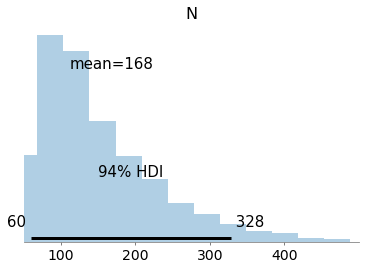

In [68]:
# Solution goes here
# Click to hide# Solution

k = 23
n = 19
x = 4

with pm.Model() as model6:
    N = pm.DiscreteUniform('N', 50, 500)
    y = pm.HyperGeometric('y', N=N, k=k, n=n, observed=x)
    trace6 = pm.sample(1000, **options)
    az.plot_posterior(trace6)


**Exercise:** In <<_TheWeibullDistribution>> we generated a sample from a Weibull distribution with $\lambda=3$ and $k=0.8$.
Then we used the data to compute a grid approximation of the posterior distribution of those parameters.

Now let's do the same with PyMC3.

For the priors, you can use uniform distributions as we did in <<_SurvivalAnalysis>>, or you could use `HalfNormal` distributions provided by PyMC3.

Note: The `Weibull` class in PyMC3 uses different parameters than SciPy.  The parameter `alpha` in PyMC3 corresponds to $k$, and `beta` corresponds to $\lambda$.

**练习：** 在 <<_TheWeibullDistribution>> 中，我们从 Weibull 分布中生成了一个样本，其中 $\lambda=3$ 和 $k=0.8$。
然后我们使用这些数据来计算这些参数的后验分布的网格近似。

现在让我们对 PyMC3 做同样的事情。

对于先验，您可以使用我们在 <<_SurvivalAnalysis>> 中所做的均匀分布，或者您可以使用 PyMC3 提供的“HalfNormal”分布。

注意：PyMC3 中的 `Weibull` 类使用与 SciPy 不同的参数。 PyMC3中的参数`alpha`对应$k$，`beta`对应$\lambda$。

Here's the data again:

In [69]:
data = [0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866,
       3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


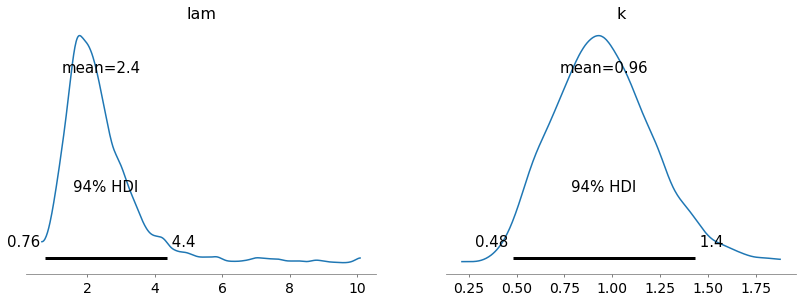

In [70]:
# Solution goes here

# Solution

with pm.Model() as model7:
    lam = pm.Uniform('lam', 0.1, 10.1)
    k = pm.Uniform('k', 0.1, 5.1)
    y = pm.Weibull('y', alpha=k, beta=lam, observed=data)
    trace7 = pm.sample(1000, **options)
    az.plot_posterior(trace7)

**Exercise:** In <<_ImprovingReadingAbility>> we used data from a reading test to estimate the parameters of a normal distribution.

Make a model that defines uniform prior distributions for `mu` and `sigma` and uses the data to estimate their posterior distributions.


**练习：** 在 <<_ImprovingReadingAbility>> 中，我们使用来自阅读测试的数据来估计正态分布的参数。

制作一个模型，定义“mu”和“sigma”的均匀先验分布，并使用数据来估计它们的后验分布。

Here's the data again.

In [74]:
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv')

In [75]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


I'll use `groupby` to separate the treated group from the control group.

In [76]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

Now estimate the parameters for the treated group.

In [77]:
data = responses['Treated']

In [78]:
# Solution goes here

data = responses['Treated']

In [79]:
# Solution goes here
# Solution

with pm.Model() as model8:
    mu = pm.Uniform('mu', 20, 80)
    sigma = pm.Uniform('sigma', 5, 30)
    y = pm.Normal('y', mu, sigma, observed=data)
    trace8 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


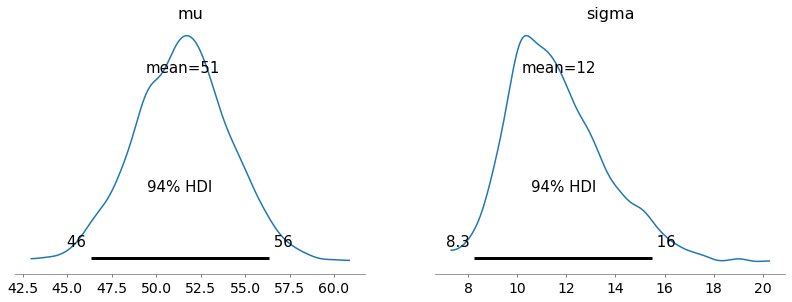

In [80]:
# Solution

with model8:
    az.plot_posterior(trace8)

**Exercise:** In <<_TheLincolnIndexProblem>> we used a grid algorithm to solve the Lincoln Index problem as presented by John D. Cook:

> "Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There's no way to know with one tester. But if you have two testers, you can get a good idea, even if you don't know how skilled the testers are."

Suppose the first tester finds 20 bugs, the second finds 15, and they
find 3 in common; use PyMC3 to estimate the number of bugs.

**练习：** 在 <<_TheLincolnIndexProblem>> 中，我们使用网格算法来解决 John D. Cook 提出的林肯指数问题：

> “假设您有一个测试人员在您的程序中发现了 20 个错误。您想估计程序中有多少错误。您知道至少有 20 个错误，如果您对测试人员有极大的信心，您可能会假设 大约有 20 个 bug。但也许你的测试人员不是很好。也许有数百个 bug。你怎么知道有多少 bug？一个测试人员无法知道。但是如果你有两个测试人员 ，你可以得到一个好主意，即使你不知道测试人员有多熟练。”

假设第一个测试人员发现了 20 个错误，第二个发现了 15 个，然后他们
找到 3 个共同点； 使用 PyMC3 估计错误的数量。

Note: This exercise is more difficult that some of the previous ones.  One of the challenges is that the data includes `k00`, which depends on `N`:

```
k00 = N - num_seen
```

So we have to construct the data as part of the model.
To do that, we can use `pm.math.stack`, which makes an array:

```
data = pm.math.stack((k00, k01, k10, k11))
```

Finally, you might find it helpful to use `pm.Multinomial`.

注意：这个练习比前面的一些练习更难。 挑战之一是数据包含“k00”，它取决于“N”：

```
k00 = N - num_seen
```

所以我们必须将数据构建为模型的一部分。
为此，我们可以使用 `pm.math.stack`，它创建一个数组：

```
数据 = pm.math.stack((k00, k01, k10, k11))
```

最后，您可能会发现使用 `pm.Multinomial` 很有帮助。

I'll use the following notation for the data:

* k11 is the number of bugs found by both testers,

* k10 is the number of bugs found by the first tester but not the second,

* k01 is the number of bugs found by the second tester but not the first, and

* k00 is the unknown number of undiscovered bugs.

Here are the values for all but `k00`:

我将对数据使用以下表示法：

* k11 是两个测试人员发现的错误数，

* k10 是第一个测试人员而不是第二个测试人员发现的错误数，

* k01 是第二个测试人员发现的但不是第一个测试人员发现的错误数，并且

* k00 是未知数量的未发现错误。

以下是除 `k00` 之外的所有值：

In [81]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

In total, 32 bugs have been discovered:

In [82]:
num_seen = k01 + k10 + k11
num_seen

32

In [83]:
# Solution goes here
k00 = N - num_seen

In [84]:
# Solution goes here
data = pm.math.stack((k00, k01, k10, k11))

In [85]:
# Solution goes here
num_seen = k01 + k10 + k11
num_seen

32

In [86]:
# Solution

with pm.Model() as model9:
    p0 = pm.Beta('p0', alpha=1, beta=1)
    p1 = pm.Beta('p1', alpha=1, beta=1)
    N = pm.DiscreteUniform('N', num_seen, 350)
    
    q0 = 1-p0
    q1 = 1-p1
    ps = [q0*q1, q0*p1, p0*q1, p0*p1]
    
    k00 = N - num_seen
    data = pm.math.stack((k00, k01, k10, k11))
    y = pm.Multinomial('y', n=N, p=ps, observed=data)

In [89]:
# Solution

with model9:
    trace9 = pm.sample(10000, **options)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p1, p0]
>Metropolis: [N]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.6988677407320162, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


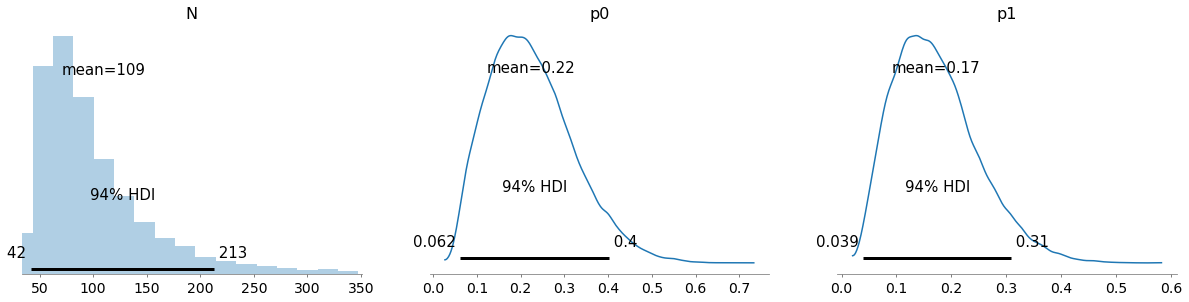

In [90]:
# Solution

with model9:
    az.plot_posterior(trace9)